In [1]:
import h5py
import numpy as np
import torch, monai
import torchio as tio
from typing import Sequence
from monai.data import ArrayDataset, DataLoader, PersistentDataset
from monai.transforms import Compose, RandAffine, Rand2DElastic, Rand3DElastic, ScaleIntensity
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
import nibabel as nib
from utils import *
import torch.nn as nn

import glob, os
from monai.transforms import (
    Compose,
    LoadImage,
    RandSpatialCrop,
    ScaleIntensity,
    RandFlip,
    RandRotate90
)

from monai.utils import first
from tqdm import tqdm
from utils import *


## 1. Create Dataloader

In [2]:
t1s_dir = 'datasets/IXI/train/t1_align' # Misaligned data # TODO: Put the proper values on 't1_misalign_#'
t2s_dir = 'datasets/IXI/train/t2'

t1s = sorted(glob.glob(os.path.join(t1s_dir, "t1*.npy")))
t2s = sorted(glob.glob(os.path.join(t2s_dir, "t2*.npy")))

t1_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            RandSpatialCrop((96, 96), random_size=False),
            RandFlip(prob=0.5, spatial_axis=0),
            RandFlip(prob=0.5, spatial_axis=1),
            RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ]
    )

t2_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            RandSpatialCrop((96, 96), random_size=False),
            RandFlip(prob=0.5, spatial_axis=0),
            RandFlip(prob=0.5, spatial_axis=1),
            RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ]
    )


# define array dataset, data loader
train_ds = ArrayDataset(t1s, t1_trans, t2s, t2_trans)
train_loader = DataLoader(train_ds, batch_size=120, num_workers=5, shuffle=True, pin_memory=torch.cuda.is_available())
# This is the trainloader


In [3]:
root_dir = 'datasets/IXI/val'

t1s = sorted(glob.glob(os.path.join(root_dir, "t1*.npy")))
t2s = sorted(glob.glob(os.path.join(root_dir, "t2*.npy")))

t1_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
        ]
    )

t2_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
        ]
    )


# define array dataset, data loader
val_ds = ArrayDataset(t1s, t1_trans, t2s, t2_trans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=5, pin_memory=torch.cuda.is_available())
# This is the val_loader


## 2. Make original? (PGAN) model

In [ ]:
class Args:
    pass

opt = {'isTrain':True, 'input_nc':1, 'output_nc':1, 'ngf':16, 'ndf':16, 
       'n_layers_D':3, 'norm':'instance','no_dropout':True,'no_lsgan':True, 'init_type':'normal', 
       'gpu_ids':[0], 'checkpoints_dir':'checkpoints', 'name':'Test', 'lambda_vgg':10.0,
       'continue_train':False, 'pool_size':0, 'lr':0.0002, 'beta1':0.5, 'lambda_adv':0.1, 'lambda_A':10.0, 'lmbda_B':10.0, 'lambda_identity':0.0,
       'lr_policy':'lambda', 'epoch_count':1, 'niter':100, 'niter_decay':100, 'which_direction':'AtoB', 'dataroot':'datasets/IXI/train'}
args = Args()
for key, value in opt.items():
    setattr(args, key, value)

from models import create_model
from models.pgan_model import pGAN

model = pGAN()  
model.initialize(args)

## 3. Run training (Epoch by Epoch)

In [ ]:

for epoch in range(1000):
    # Training Stage
    for i, (t1, t2) in enumerate(train_loader): # Train images with patch 96x96
        model.set_input({'A':t1, 'B':t2})
        model.optimize_parameters()
        
    if epoch % 10 == 0:
        # Validation Stage
        psnr, ssim = 0, 0
        for i, (t1, t2) in enumerate(val_loader): # Test it with full FOV
            model.set_input({'A':t1, 'B':t2})
            _psnr, _ssim = model.test()
            psnr += _psnr
            ssim += _ssim
            if i == 0:
                out = model.get_current_visuals()
                plot_images([out['real_A'], out['fake_B'], out['real_B']], ['Real_A', 'Fake_B', 'Real_B']) #TODO: 회색조 이미지를 정상적으로 만들기
        print(f"Epoch {epoch}, Iter {i}, PSNR {psnr/len(val_loader)}, SSIM {ssim/len(val_loader)}")


## 4. Modify the network with monai.GenerativeModels
See `https://github.com/Project-MONAI/GenerativeModels/blob/main/tutorials/generative/2d_autoencoderkl/2d_autoencoderkl_tutorial.ipynb`

In [4]:
from GenerativeModels.generative.losses import PatchAdversarialLoss, PerceptualLoss
from GenerativeModels.generative.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.config import print_config
from monai.networks.nets import AttentionUnet
from torch.nn import L1Loss
from tqdm import tqdm
from monai.networks.layers import Act

import time
from GenerativeModels.generative.losses import PatchAdversarialLoss, PerceptualLoss
from GenerativeModels.generative.networks.nets import AutoencoderKL, PatchDiscriminator
print_config()

MONAI version: 1.1.0
Numpy version: 1.24.3
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/milab/anaconda3/envs/danny_misalign/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.5.0
Tensorboard version: 2.13.0
gdown version: 4.7.1
TorchVision version: 0.15.2+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-t

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(3) #TODO: Put the proper values
print(f"Using {device}")

model = AttentionUnet(spatial_dims=2, in_channels=1, out_channels=1, channels=[32,64,128,256], strides=[1,2,2,2]) # Strides: downsampling layers
model.to(device)

discriminator = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    num_channels=64,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator.to(device)

perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="radimagenet_resnet50")
perceptual_loss.to(device)

optimizer_g = torch.optim.Adam(params=model.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=5e-4)

l1_loss = L1Loss()
adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01
perceptual_weight = 0.001

# PGAN : l1_loss + adv_loss + perceptual_loss

Using cuda


Saving directroy: ./checkpoints/pGAN_run3


Epoch 0:   0%|                                                                         | 0/19 [00:00<?, ?it/s]/home/milab/anaconda3/envs/danny_misalign/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/milab/anaconda3/envs/danny_misalign/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/milab/anaconda3/envs/danny_misalign/lib/python3.9/site-packages/torc

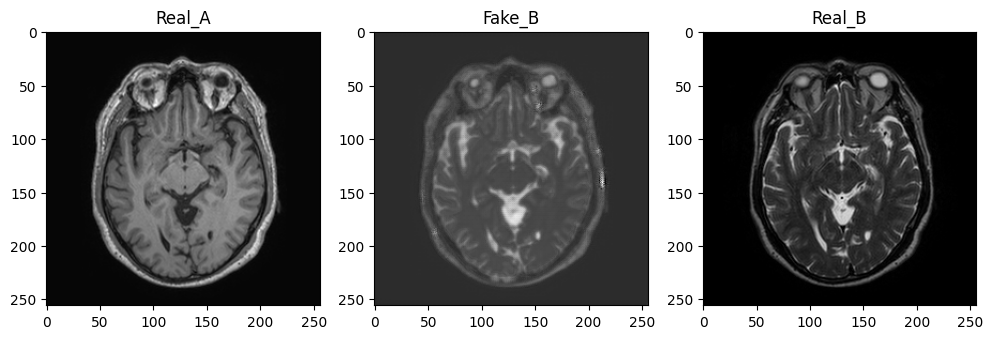

Validation Loss:  0.039166844210454396 Average PSNR:  22.166582937555 Average SSIM:  0.6136463960448464


Epoch 39: 100%|███████████| 19/19 [00:07<00:00,  2.42it/s, recons_loss=0.048, gen_loss=0.621, disc_loss=0.309]


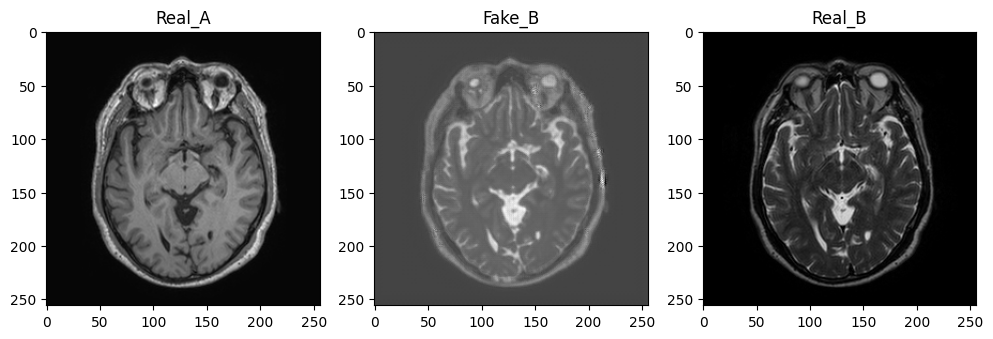

Validation Loss:  0.028471113901053155 Average PSNR:  24.421107474526206 Average SSIM:  0.7857746460935572


Epoch 59: 100%|██████████| 19/19 [00:08<00:00,  2.37it/s, recons_loss=0.0444, gen_loss=0.414, disc_loss=0.236]


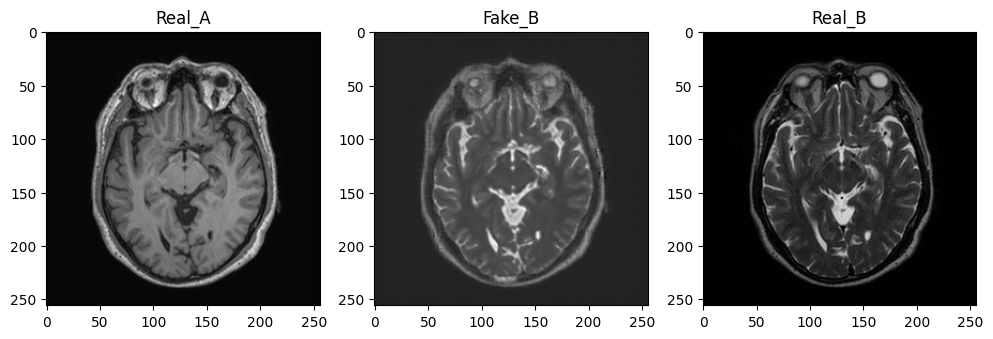

Validation Loss:  0.02717704123684338 Average PSNR:  24.759077478765132 Average SSIM:  0.8044348602766519


Epoch 79: 100%|██████████| 19/19 [00:07<00:00,  2.38it/s, recons_loss=0.0423, gen_loss=0.317, disc_loss=0.224]


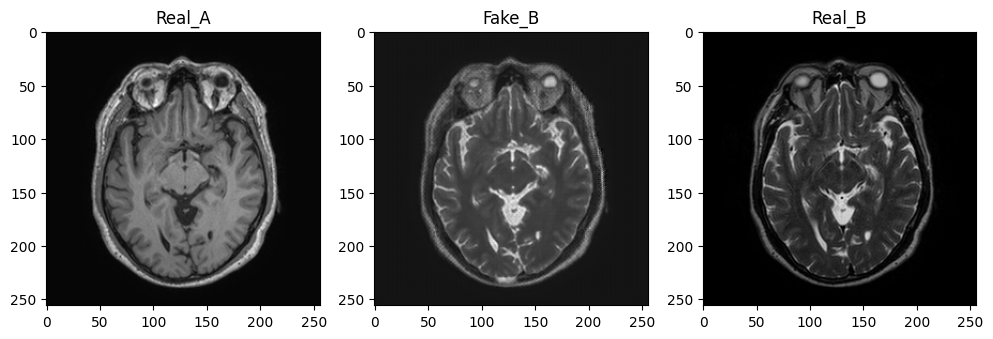

Validation Loss:  0.027923043235972687 Average PSNR:  24.570873952173926 Average SSIM:  0.8187717148235866


Epoch 99: 100%|███████████| 19/19 [00:08<00:00,  2.37it/s, recons_loss=0.0407, gen_loss=0.319, disc_loss=0.24]


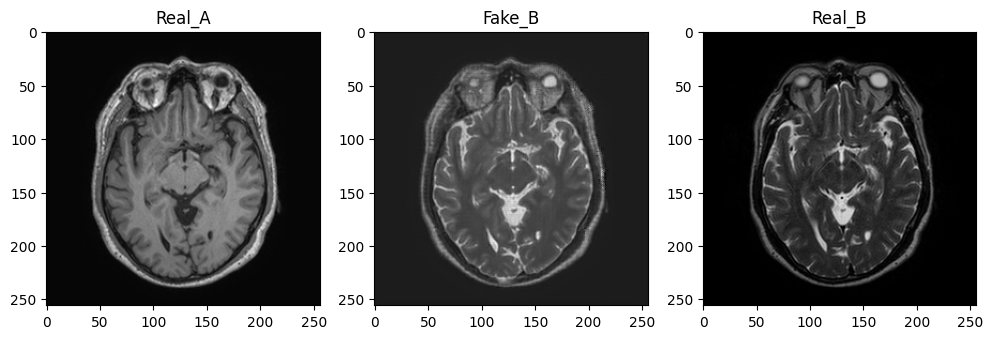

Validation Loss:  0.02579893327348835 Average PSNR:  25.322451174390185 Average SSIM:  0.8137517267531091


Epoch 119: 100%|██████████| 19/19 [00:07<00:00,  2.40it/s, recons_loss=0.039, gen_loss=0.524, disc_loss=0.305]


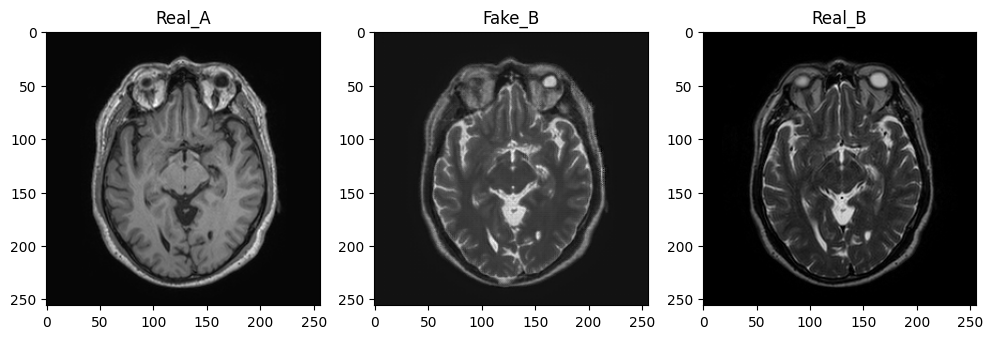

Validation Loss:  0.026416113997226234 Average PSNR:  24.877490066695998 Average SSIM:  0.8259804489848378


Epoch 139: 100%|█████████| 19/19 [00:07<00:00,  2.41it/s, recons_loss=0.0391, gen_loss=0.303, disc_loss=0.233]


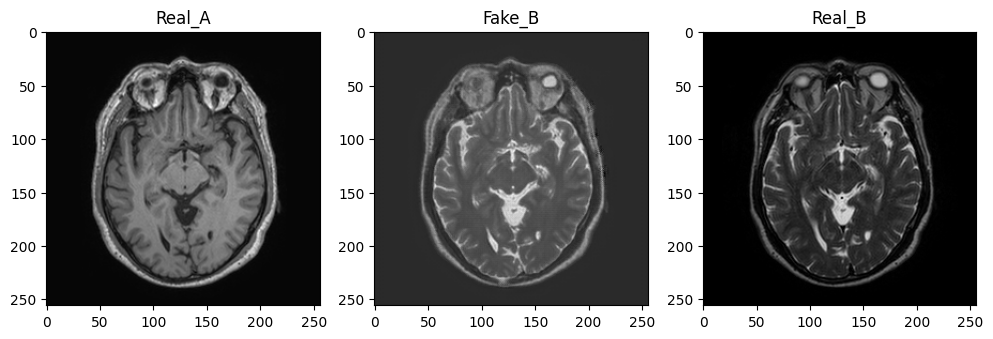

Validation Loss:  0.025485615243951043 Average PSNR:  25.344274663401173 Average SSIM:  0.8209807289825691


Epoch 141:  58%|█████▏   | 11/19 [00:05<00:03,  2.57it/s, recons_loss=0.0381, gen_loss=0.311, disc_loss=0.242]

In [6]:
# Example from : https://github.com/Project-MONAI/GenerativeModels/blob/main/tutorials/generative/2d_autoencoderkl/2d_autoencoderkl_tutorial.ipynb

from torch.nn.functional import mse_loss
from pytorch_msssim import ssim

n_epochs = 300
val_interval = 20
epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4
train_save_dir = './checkpoints/pGAN_run'
base_dir = train_save_dir

# Check if directory exists. If it does, append a number to it
i = 1
while os.path.exists(train_save_dir):
    train_save_dir = base_dir + str(i)
    i += 1

os.makedirs(train_save_dir, exist_ok=True)
print("Saving directroy:", train_save_dir)

total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, (t1,t2) in progress_bar:
        t1 = t1.to(device)
        t2 = t2.to(device)
        optimizer_g.zero_grad(set_to_none=True)

        reconstruction = model(t1)

        recons_loss = l1_loss(reconstruction.float(), t2.float()) # L1 loss

        logits_fake = discriminator(reconstruction.contiguous().float())[-1]
        p_loss = perceptual_loss(reconstruction.float(), t2.float()) # Perceptual loss
        generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False) # Adversarial loss
        loss_g = recons_loss + perceptual_weight * p_loss + adv_weight * generator_loss

        loss_g.backward()
        optimizer_g.step()

        # Discriminator part (Updating discriminator)
        optimizer_d.zero_grad(set_to_none=True)

        logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
        loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
        logits_real = discriminator(t2.contiguous().detach())[-1]
        loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
        discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

        loss_d = adv_weight * discriminator_loss

        loss_d.backward()
        optimizer_d.step() # Updating discriminator

        epoch_loss += recons_loss.item()
        gen_epoch_loss += generator_loss.item()
        disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_gen_loss_list.append(gen_epoch_loss / (step + 1))
    epoch_disc_loss_list.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:

        # Save the model
        model_save_path = os.path.join(train_save_dir, f'model_G_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), model_save_path)
        model_save_path = os.path.join(train_save_dir, f'model_D_epoch_{epoch+1}.pth')
        torch.save(discriminator.state_dict(), model_save_path)
        

        model.eval()
        val_loss = 0
        total_psnr = 0
        total_ssim = 0
        with torch.no_grad():
            for val_step, (t1,t2) in enumerate(val_loader, start=1):
                t1 = t1.to(device)
                t2 = t2.to(device)
                reconstruction = model(t1)



                # get the first sammple from the first validation batch for visualisation
                # purposes
                recons_loss = l1_loss(reconstruction.float(), t2.float())

                val_loss += recons_loss.item()

                 # Calculate PSNR
                mse_val = mse_loss(reconstruction.float(), t2.float())
                psnr = 10 * torch.log10(1 / mse_val)
                total_psnr += psnr.item()

                # Calculate SSIM
                ssim_val = ssim(reconstruction.float(), t2.float(), data_range=1.0, size_average=True) # data_range: 0~1
                total_ssim += ssim_val.item()

                if val_step == 25:
                    intermediary_images.append(reconstruction[:n_example_images, 0])
                    out = get_current_visuals_for_pgan(t1.float(),reconstruction.float(),t2.float())
                    images = [out['real_A'], out['fake_B'], out['real_B']]
                    image_names = ['Real_A', 'Fake_B', 'Real_B']
                    image_save_dir = os.path.join(train_save_dir,'val_images')
                    os.makedirs(image_save_dir, exist_ok=True)
                    plot_images(images, image_names)
                    save_images(images, image_names, image_save_dir, epoch+1)

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)
        
        avg_psnr = total_psnr / val_step
        avg_ssim = total_ssim / val_step

         # Print the PSNR and SSIM values along with the loss
        print("Validation Loss: ", val_loss, "Average PSNR: ", avg_psnr, "Average SSIM: ", avg_ssim)
        with open(os.path.join(train_save_dir, 'val_PSNR,SSIM.txt'), 'a') as f:
            f.write(f'Epoch: {epoch+1}, Val Loss: {val_loss}, PSNR: {avg_psnr}, SSIM: {avg_ssim}\n')


total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

In [ ]:
# TODO: Step2_PGAN.ipynb -> Step2_PGAN_daniel.ipynb 로 정리     => DONE
# TODO: Add scaling the images (too grayish)                    => 질문!
# TODO: Make CycleGAN model, L1-loss model                      => CycleGAN DONE. Need to feedback
# TODO: train_pgan.py, train_cgan.py, train_l1loss.py 로 정리
# TODO: Add saving PSNR & SSIM                                  => DONE
# TODO: evaluate.ipynb

In [ ]:
import pytorch_lightning as pl

class MyModel(pl.LightningModule):

    def __init__(self, model, discriminator, l1_loss, perceptual_loss, adv_loss, perceptual_weight, adv_weight):
        super().__init__()
        self.model = model
        self.discriminator = discriminator
        self.l1_loss = l1_loss
        self.perceptual_loss = perceptual_loss
        self.adv_loss = adv_loss
        self.perceptual_weight = perceptual_weight
        self.adv_weight = adv_weight

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx, optimizer_idx):
        t1, t2 = batch
        t1 = t1.to(self.device)
        t2 = t2.to(self.device)

        # Generator update
        if optimizer_idx == 0:
            self.optimizers()[0].zero_grad()
            reconstruction = self(t1)
            recons_loss = self.l1_loss(reconstruction.float(), t2.float())
            logits_fake = self.discriminator(reconstruction.contiguous().float())[-1]
            p_loss = self.perceptual_loss(reconstruction.float(), t2.float())
            generator_loss = self.adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
            loss_g = recons_loss + self.perceptual_weight * p_loss + self.adv_weight * generator_loss
            self.log('train_gen_loss', loss_g)
            return loss_g

        # Discriminator update
        if optimizer_idx == 1:
            self.optimizers()[1].zero_grad()
            logits_fake = self.discriminator(reconstruction.contiguous().detach())[-1]
            loss_d_fake = self.adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
            logits_real = self.discriminator(t2.contiguous().detach())[-1]
            loss_d_real = self.adv_loss(logits_real, target_is_real=True, for_discriminator=True)
            discriminator_loss = (loss_d_fake + loss_d_real) * 0.5
            loss_d = self.adv_weight * discriminator_loss
            self.log('train_disc_loss', loss_d)
            return loss_d

    def validation_step(self, batch, batch_idx):
        t1, t2 = batch
        t1 = t1.to(self.device)
        t2 = t2.to(self.device)
        reconstruction = self(t1)
        recons_loss = self.l1_loss(reconstruction.float(), t2.float())
        self.log('val_loss', recons_loss)

    def configure_optimizers(self):
        optimizer_g = torch.optim.Adam(self.model.parameters(), lr=0.0002)
        optimizer_d = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002)
        return optimizer_g, optimizer_d



In [ ]:
print(model)